![Alt Text](Images/apple-google.png)

# Apple-Google Sentiment Analyzer

<span style="display:block; height: 3px; border: 0; border-top: 3px solid #000; margin: 1em 0; padding: 0;" ></span>

**Introduction**

The South by Southwest Conference (SXSW) is one of the largest tech and media conferences in the world, attracting a diverse range of attendees from developers and entrepreneurs to marketers and social media influencers. During this event, companies like Apple and Google showcase their latest products and technologies, and engage with attendees to gather feedback and build buzz. However, with so much activity taking place at SXSW, it can be difficult for companies to keep track of how customers are feeling about their products and how those feelings may be influencing purchasing decisions.

**The Business Problem:** 

As an industry leader, it is important for Apple and Google to understand the sentiment of their customers during the SXSW conference. The problem is that with so much noise on social media, it is challenging to manually analyze and classify customer sentiment towards their products. By ignoring or not properly analyzing customer sentiment, Apple and Google may miss out on valuable opportunities to improve customer satisfaction, make data-driven business decisions, and ultimately increase revenue.

**The Solution:** 

One potential solution is to leverage sentiment analysis to automatically classify and analyze the customer sentiment towards Apple and Google products during the SXSW conference. By using natural language processing and machine learning algorithms, sentiment analysis can help categorize the tweets collected from Twitter as positive, negative or neutral, thus making it easier for Apple and Google to track customer sentiment and respond to issues quickly. This information can be used to improve customer experience and shape the direction of product development for both companies.

**The Data:** 

The data used for this project comes from CrowdFlower via https://data.world/crowdflower/brands-and-product-emotions, which consists of approximately 9,000 tweets collected during the 2011 South by Southwest Conference. Each tweet in the dataset is labeled as negative, neutral or positive. With this dataset, we can use machine learning algorithms to train models that can predict the sentiment of new tweets and gain insights on customer sentiment towards Apple and Google products during the conference.

## Data Preprocessing - Inspection

In [1]:
!ls Data

tweets.csv


In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import spacy
import re
from textblob import TextBlob
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [3]:
df = pd.read_csv('Data/tweets.csv', encoding = 'ISO-8859-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
df.tail()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [6]:
df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [7]:
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

## Data Preprocessing - Cleaning

In [8]:
# Renaminmg my columns
df = df.rename(columns = {'tweet_text': 'Tweets', 'emotion_in_tweet_is_directed_at': 'Product/Brand', 
                         'is_there_an_emotion_directed_at_a_brand_or_product': 'Sentiment'})
df.head()

,Tweets,Product/Brand,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [9]:
df['Sentiment'].unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

In [10]:
df['Product/Brand'].unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

In [11]:
# Renaming the values in Sentiment column to "Positive, Negative, Neutral & Unclear"
sentiment_map = {'Positive emotion': 'Positive', 'Negative emotion': 'Negative', 
                            'No emotion toward brand or product': 'Neutral', "I can't tell": 'Unclear'}
df['Sentiment'] = df['Sentiment'].map(sentiment_map)

In [12]:
df['Sentiment'].value_counts()

Neutral     5389
Positive    2978
Negative     570
Unclear      156
Name: Sentiment, dtype: int64

In [13]:
df['Product/Brand'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: Product/Brand, dtype: int64

In [14]:
print("Number of missing values in 'Sentiment' column:", df['Sentiment'].isna().sum())

Number of missing values in 'Sentiment' column: 0


In [15]:
# Check for the number of missing values in the 'Tweets' column
print("Number of missing values in 'Tweets' column:", df['Tweets'].isna().sum())

Number of missing values in 'Tweets' column: 1


In [16]:
# Dropping the single missing value in 'Tweets' to avoid errors and inconsistencies during analysis.
df = df.dropna(subset = ['Tweets'])

In [17]:
# Confirm the row has been dropped
print("Number of missing values in 'Tweets' column after dropping:", df['Tweets'].isna().sum())

Number of missing values in 'Tweets' column after dropping: 0


In [18]:
print("Number of missing values in 'Product/Brand' column:" ,df['Product/Brand'].isna().sum())

Number of missing values in 'Product/Brand' column: 5801


In [19]:
df['Product/Brand'].head(10)

0                 iPhone
1     iPad or iPhone App
2                   iPad
3     iPad or iPhone App
4                 Google
5                    NaN
7                Android
8     iPad or iPhone App
9                  Apple
10               Android
Name: Product/Brand, dtype: object

Since we have 5801 missing values in the Product/Brand column, we need to fill in these missing values in order to use this data in our analysis. In order to do this, we are using the spaCy library to extract named entities from the tweets in the dataset. We are specifically looking for company names in the tweets, so we are extracting entities with the label 'ORG', which represents organizations. We then store these company names in a list called 'company_names'. We can then use this list to fill in the missing values in the Product/Brand column. 

To do this, we create a dictionary mapping the company names we found to their corresponding products or brands. We then loop through each row in the dataset and fill in missing values in the Product/Brand column using the dictionary. If a tweet mentions more than one company name, we use the first company name we find. By filling in these missing values, we can use this data to perform our analysis and gain insights into the sentiment of these tweets towards different products and brands.

In [20]:
# Load the small English model
nlp = spacy.load('en_core_web_sm')

# Create a list to store the extracted company names
company_names = []

# Loop through each tweet in the dataset
for tweet in df['Tweets']:
    # Use spaCy to extract the named entities from the tweet
    doc = nlp(tweet)
    for ent in doc.ents:
        # Check if the entity is an organization and add it to the list if it is
        if ent.label_ == 'ORG':
            company_names.append(ent.text)

# Print the first 50 unique company names
print(list(company_names)[:50])

['SXSW', 'SXSW', 'SXSW', 'Fri #SXSW', 'Google', 'SXSW', 'CTIA', 'Apple', 'Android', 'SXSW', 'SXSW', '@Gowalla', '=&', 'iPad', 'iPad', 'DST', 'iPhone', 'SXSW', 'SXSW', 'SXSW', 'Forbes', 'SXSW', 'iPad', 'iPad', 'Gowalla 3.0', 'Android', 'SXSW', 'SXSW', 'iPad', 'RT', 'iPad', 'Android', 'iPad', 'iPad', 'SXSW', 'iPad', 'SXSW', 'iPad', 'iPad', 'RT @mention Google', 'New Social Network Called Circles', 'Apple', 'iPad', '@mention &', 'VatorNews - Google', 'Apple Force', 'HootSuite - HootSuite Mobile', 'SXSW', 'BlackBerry &', 'Android']


In [21]:
# Create a dictionary of company names and corresponding keywords to search for in tweets
company_keywords = {'Apple': ['apple', 'iphone', 'ipad'], 'Google': ['google', 'android']}

# Loop through each row in the dataset and fill in missing values in the 'Product/Brand' column
for i, row in df.iterrows():
    tweet = row['Tweets']
    product_brand = row['Product/Brand']
    if pd.isna(product_brand):
        for company, keywords in company_keywords.items():
            for keyword in keywords:
                if re.search(keyword, tweet, re.IGNORECASE):
                    df.at[i, 'Product/Brand'] = company
                    break
            if not pd.isna(df.at[i, 'Product/Brand']):
                break

The above code creates a dictionary called 'company_keywords' which contains the company names as keys and a list of keywords associated with each company as the corresponding values.

Then, it loops through each row in the dataset and fills in the missing values in the 'Product/Brand' column. It first checks if the 'Product/Brand' value is missing, and if it is, it loops through the 'company_keywords' dictionary to look for keywords associated with each company.

It then searches for the keywords in the tweet text using regular expressions and if a keyword is found, it assigns the corresponding company name to the 'Product/Brand' column of that row in the dataframe. The loop stops once a company name has been assigned or if all the keywords have been checked and no matches are found.

This code helps to fill in missing values in the 'Product/Brand' column based on the keywords associated with each company.

In [22]:
print("Number of missing in 'Product/Brand' column after filling:", df['Product/Brand'].isna().sum())

Number of missing in 'Product/Brand' column after filling: 761


In [23]:
# Dropping the 761 missing values in the Product/Brand column since may result in errors and inconsistencies
df.dropna(subset = ['Product/Brand'], inplace = True)

In [24]:
print("Number of missing in 'Product/Brand' column after dropping:", df['Product/Brand'].isna().sum())

Number of missing in 'Product/Brand' column after dropping: 0


In [25]:
df['Product/Brand'].value_counts()

Apple                              3779
Google                             2352
iPad                                946
iPad or iPhone App                  470
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: Product/Brand, dtype: int64

In [26]:
# Checking tweets with unclear sentiments to see if we could find a pattern to whether the tweet has a 
# Negative, Neutral, or positive Sentiment.

# Get the rows with unclear sentiment
pd.set_option("display.max_colwidth", 300)
df[df['Sentiment'] == 'Unclear']

,Tweets,Product/Brand,Sentiment
102,ÛÏ@mention &quot;Apple has opened a pop-up store in Austin so the nerds in town for #SXSW can get their new iPads. {link} #wow,Apple,Unclear
237,"Just what America needs. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",Google,Unclear
341,The queue at the Apple Store in Austin is FOUR blocks long. Crazy stuff! #sxsw,Apple,Unclear
368,Hope it's better than wave RT @mention Buzz is: Google's previewing a social networking platform at #SXSW: {link},Google,Unclear
413,SYD #SXSW crew your iPhone extra juice pods have been procured.,Apple,Unclear
...,...,...,...
9020,It's funny watching a room full of people hold their iPad in the air to take a photo. Like a room full of tablets staring you down. #SXSW,Apple,Unclear
9032,"@mention yeah, we have @mention , Google has nothing on us :) #SXSW",Google,Unclear
9037,"@mention Yes, the Google presentation was not exactly what I was expecting. #sxsw",Google,Unclear
9058,&quot;Do you know what Apple is really good at? Making you feel bad about your Xmas present!&quot; - Seth Meyers on iPad2 #sxsw #doyoureallyneedthat?,Apple,Unclear


In [27]:
print('Number of unclear sentiments in the "Sentiments" column:', df['Sentiment'].value_counts()['Unclear'])

Number of unclear sentiments in the "Sentiments" column: 150


In [28]:
from textblob import TextBlob
# Filtering the unclear sentiments using TextBlob to determine whether they are Positive, Negative, or Neutral
unclear_sentiment = df[df['Sentiment'] == 'Unclear'].copy()

# Define a function to classify the sentiment of a tweet
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    if sentiment > 0:
        return 'Positive'
    elif sentiment < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to the 'Tweets' column of the unclear sentiments DataFrame
unclear_sentiment['Sentiment'] = unclear_sentiment['Tweets'].apply(get_sentiment)

# Print the first 10 rows of the DataFrame to see the results
unclear_sentiment.head(10)

,Tweets,Product/Brand,Sentiment
102,ÛÏ@mention &quot;Apple has opened a pop-up store in Austin so the nerds in town for #SXSW can get their new iPads. {link} #wow,Apple,Positive
237,"Just what America needs. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",Google,Positive
341,The queue at the Apple Store in Austin is FOUR blocks long. Crazy stuff! #sxsw,Apple,Negative
368,Hope it's better than wave RT @mention Buzz is: Google's previewing a social networking platform at #SXSW: {link},Google,Negative
413,SYD #SXSW crew your iPhone extra juice pods have been procured.,Apple,Neutral
441,Why Barry Diller thinks iPad only content is nuts @mention #SXSW {link},Apple,Neutral
488,Gave into extreme temptation at #SXSW and bought an iPad 2... #impulse,Apple,Negative
640,Catch 22Û_ I mean iPad 2 at #SXSW : {link},Apple,Negative
705,Forgot my iPhone for #sxsw. Android only. Knife to a gun fight,Apple,Neutral
745,Kawasaki: key to enchantment = trustworthiness of Zappos + likeability of Richard Branson + product of Apple #sxsw #mccannsxsw #mrmworldwide,Apple,Neutral


In [29]:
# Updating the Sentiment column of the original dataframe with the new sentiment values
for index, row in unclear_sentiment.iterrows():
    df.loc[df['Tweets'] == row['Tweets'], 'Sentiment'] = row['Sentiment']

In [30]:
df[df['Sentiment'] == 'Unclear']
df.head(10)

,Tweets,Product/Brand,Sentiment
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,Apple,Neutral
7,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive
8,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,iPad or iPhone App,Positive
9,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,Positive
10,Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still running Android 2.1. #fail,Android,Positive


In [31]:
df['Sentiment'].value_counts()

Neutral     4713
Positive    3020
Negative     598
Name: Sentiment, dtype: int64

In [32]:
print("Number of duplicates in our data:", df.duplicated().sum())

Number of duplicates in our data: 20


In [33]:
df.drop_duplicates(inplace = True)

In [34]:
print("Number of duplicates in our data after dropping them:", df.duplicated().sum())

Number of duplicates in our data after dropping them: 0


## Data Preprocessing - Feature Engineering

In [35]:
df['Company'] = df['Product/Brand']

# Replace product/brand names with company names
df['Company'].replace({'Apple': 'Apple', 'Google': 'Google', 'iPad': 'Apple', 'iPad or iPhone App': 'Apple',
                        'iPhone': 'Apple', 'Other Apple product or service': 'Apple',
                        'Other Google product or service': 'Google', 'Android': 'Google', 'Android App': 'Google'},
                       inplace=True)

# Print the value counts for the 'Company' column
print(df['Company'].value_counts())

Apple     5522
Google    2789
Name: Company, dtype: int64


In [36]:
df.head()

,Tweets,Product/Brand,Sentiment,Company
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,Apple
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,Apple
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,Apple
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,Apple
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive,Google


In [37]:
# Group by company name and create a dictionary of dataframes for each company
company_dfs = {company: df.loc[df['Company'] == company] for company in df['Company'].unique()}

# Print the sentiment value counts for each company
for company, company_df in company_dfs.items():
    print(f"Sentiment value counts for {company}:\n{company_df['Sentiment'].value_counts()}\n")

Sentiment value counts for Apple:
Neutral     2918
Positive    2170
Negative     434
Name: Sentiment, dtype: int64

Sentiment value counts for Google:
Neutral     1784
Positive     842
Negative     163
Name: Sentiment, dtype: int64



## Exploratory Data Analysis

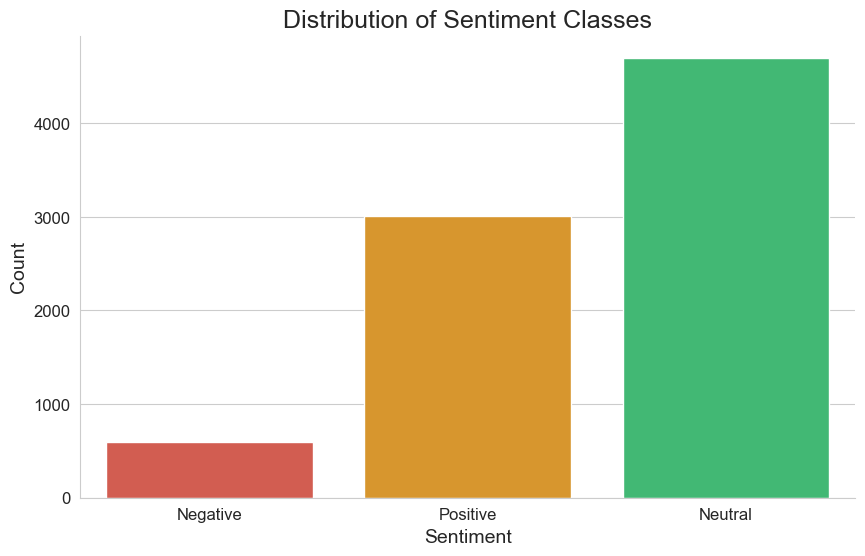

In [38]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Define custom colors
plt_colors = ['#E74C3C', '#F39C12', '#2ECC71']

# Plot a countplot of the 'Sentiment' column
sns.countplot(x = 'Sentiment', data = df, palette = plt_colors)

# Set the title of the plot and customize font size
plt.title('Distribution of Sentiment Classes', fontsize = 18)

# Set x-axis label font size
plt.xlabel('Sentiment', fontsize = 14)

# Set y-axis label font size
plt.ylabel('Count', fontsize = 14)

# Set tick label font size
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Remove top and right spines
sns.despine(top = True, right = True)

# Show the plot
plt.show()

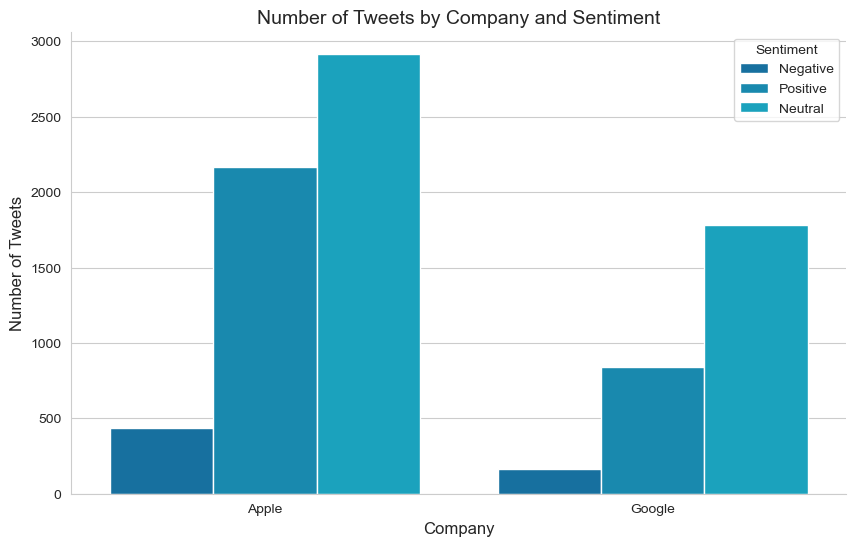

In [39]:
# Set plot style and figure size
sns.set_style("whitegrid")
plt.figure(figsize = (10, 6))

# Set custom color palette
colors = ["#0077B6", "#0096C7", "#00B4D8", "#48CAE4", "#90E0EF", "#ADE8F4", "#CAF0F8"]

# Plot bar chart
ax = sns.countplot(data=df, x='Company', hue='Sentiment', palette = colors)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set x and y labels
ax.set_xlabel('Company', fontsize = 12)
ax.set_ylabel('Number of Tweets', fontsize = 12)

# Set tick label size
ax.tick_params(labelsize = 10)

# Set legend
ax.legend(title = 'Sentiment', fontsize=10)

# Set title
plt.title('Number of Tweets by Company and Sentiment', fontsize=14)

# Show plot
plt.show()

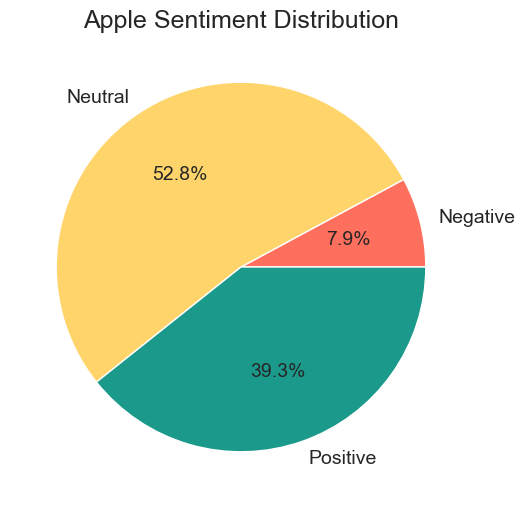

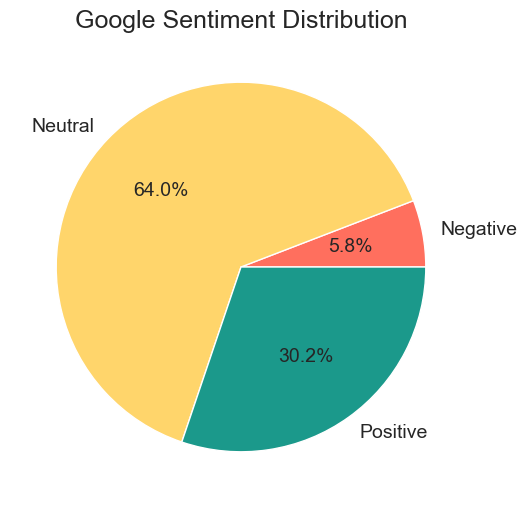

In [40]:
# Create a pivot table to calculate the count of each sentiment by company
pivot = df.pivot_table(index='Company', columns='Sentiment', values='Tweets', aggfunc='count', fill_value=0)

# Plot a pie chart for each company
for company in pivot.index:
    # Get the sentiment counts for the current company
    sentiment_counts = pivot.loc[company].values
    # Get the labels for the sentiment counts
    sentiment_labels = pivot.columns.values
    # Create a pie chart for the current company with custom colors and font sizes
    plt.figure(figsize=(6,6))
    plt.pie(sentiment_counts, labels=sentiment_labels, colors = ['#ff6f5e', '#ffd56b', '#1b998b'],
            autopct='%1.1f%%', textprops={'fontsize': 14})
    plt.title(f'{company} Sentiment Distribution', fontsize=18)
    plt.show()

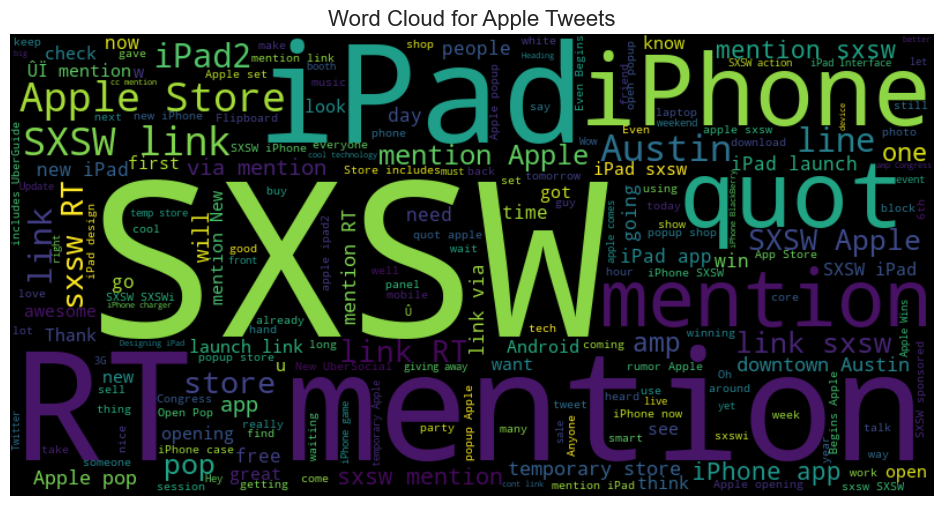

In [41]:
# Get the text for Apple tweets
apple_text = df[df['Company'] == 'Apple']['Tweets'].str.cat(sep = ' ')

# Generate the word cloud
wordcloud = WordCloud(width = 800, height = 400, background_color = 'Black').generate(apple_text)

# Set the figure size and title
plt.figure(figsize = (12,6))
plt.title('Word Cloud for Apple Tweets', fontsize=16)

# Display the word cloud
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

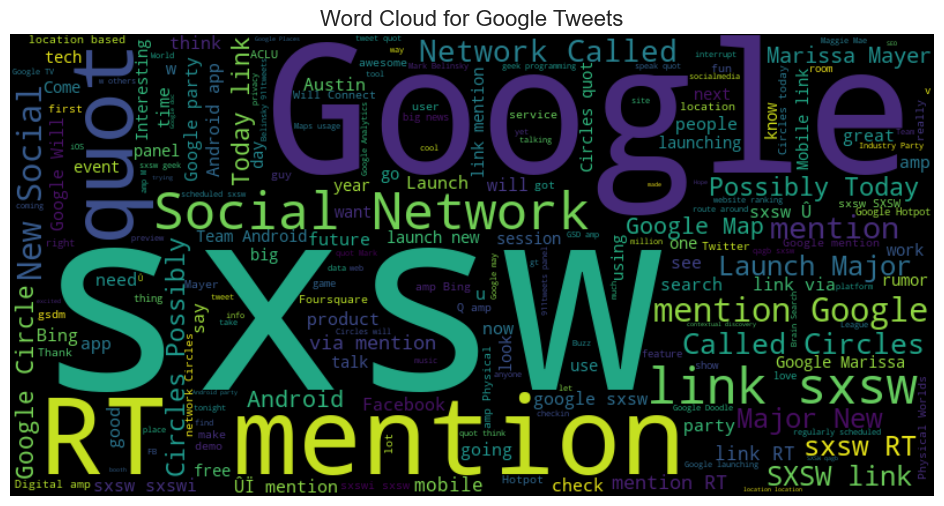

In [42]:
# Get the text for Google tweets
apple_text = df[df['Company'] == 'Google']['Tweets'].str.cat(sep = ' ')

# Generate the word cloud
wordcloud = WordCloud(width = 800, height = 400, background_color = 'Black').generate(apple_text)

# Set the figure size and title
plt.figure(figsize = (12,6))
plt.title('Word Cloud for Google Tweets', fontsize=16)

# Display the word cloud
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

## Data Preparation For Modeling

In [43]:
# Transforming Tweets column text to lowercases
df['Tweets'] = df['Tweets'].str.lower()

In [44]:
# Remove URLS from the Tweets column using lambda and re'
df['Tweets'] = df['Tweets'].apply(lambda x: re.sub(r'http\S+', '', x))

In [45]:
# Remove mentions from the Tweets column using lambda and re'
df['Tweets'] = df['Tweets'].apply(lambda x: re.sub(r'@\w+', '', x))

In [46]:
# Remove punctuations from the Tweets column using lambda and re'
df['Tweets'] = df['Tweets'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [47]:
# Remove stopwords from the Tweets column using lambda
stop_words = set(stopwords.words('english'))
df['Tweets'] = df['Tweets'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

In [48]:
# Lemmatize the Tweets column to reduce every word to its base form
lemmatizer = WordNetLemmatizer()

# Define a function to lemmatize a list of words
def lemmatize_words(words):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return lemmatized_words

# Split the Tweets column into individual tokens and apply lemmatization to each token
df['Tweets'] = df['Tweets'].apply(lambda x: x.split())
df['Tweets'] = df['Tweets'].apply(lemmatize_words)

# Print out the original words and their lemmatized versions
for i, row in df.head().iterrows():
    print('Original words:', row['Tweets'])
    print('Lemmatized words:', lemmatize_words(row['Tweets']))
    print()

Original words: ['3g', 'iphone', '3', 'hr', 'tweeting', 'rise_austin', 'dead', 'need', 'upgrade', 'plugin', 'station', 'sxsw']
Lemmatized words: ['3g', 'iphone', '3', 'hr', 'tweeting', 'rise_austin', 'dead', 'need', 'upgrade', 'plugin', 'station', 'sxsw']

Original words: ['know', 'awesome', 'ipadiphone', 'app', 'youll', 'likely', 'appreciate', 'design', 'also', 'theyre', 'giving', 'free', 't', 'sxsw']
Lemmatized words: ['know', 'awesome', 'ipadiphone', 'app', 'youll', 'likely', 'appreciate', 'design', 'also', 'theyre', 'giving', 'free', 't', 'sxsw']

Original words: ['wait', 'ipad', '2', 'also', 'sale', 'sxsw']
Lemmatized words: ['wait', 'ipad', '2', 'also', 'sale', 'sxsw']

Original words: ['hope', 'year', 'festival', 'isnt', 'crashy', 'year', 'iphone', 'app', 'sxsw']
Lemmatized words: ['hope', 'year', 'festival', 'isnt', 'crashy', 'year', 'iphone', 'app', 'sxsw']

Original words: ['great', 'stuff', 'fri', 'sxsw', 'marissa', 'mayer', 'google', 'tim', 'oreilly', 'tech', 'booksconferen

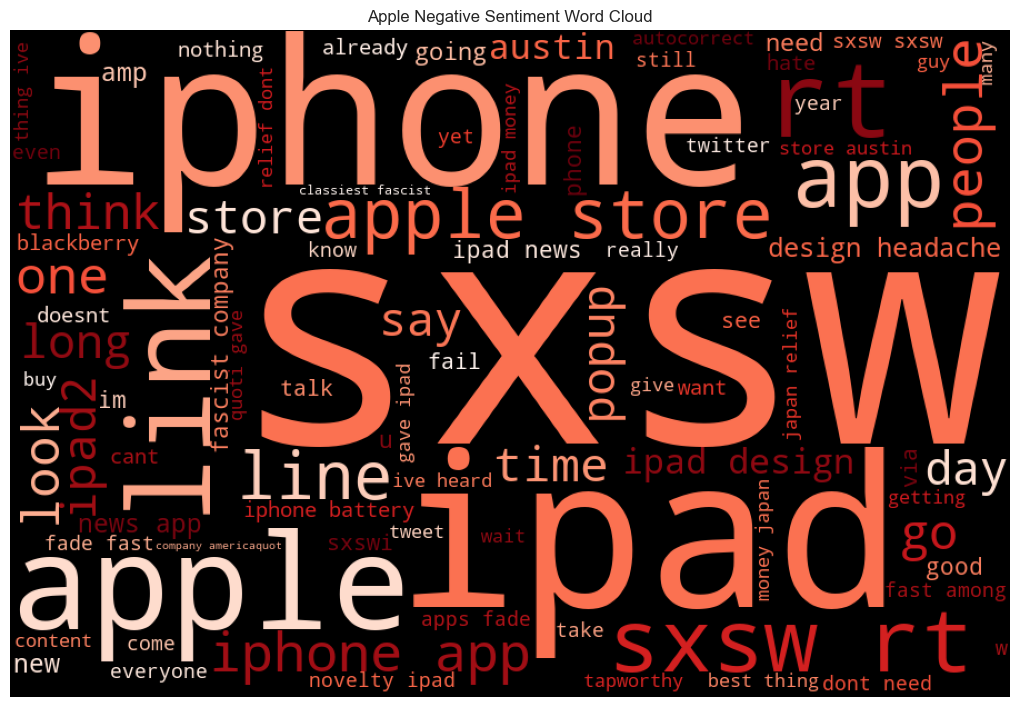

In [49]:
apple_neg_tweets = df[(df['Company']=='Apple') & (df['Sentiment']=='Negative')]['Tweets'].tolist()

# Join all tweets together into a single string
apple_neg_words = ' '.join([tweet for sublist in apple_neg_tweets for tweet in sublist])

# Create a word cloud for negative sentiment words for Apple
wordcloud = WordCloud(width = 900, height = 600, background_color ='Black', min_font_size = 10, 
                      colormap = 'Reds').generate(apple_neg_words)
plt.figure(figsize = (10, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Apple Negative Sentiment Word Cloud")
plt.show()

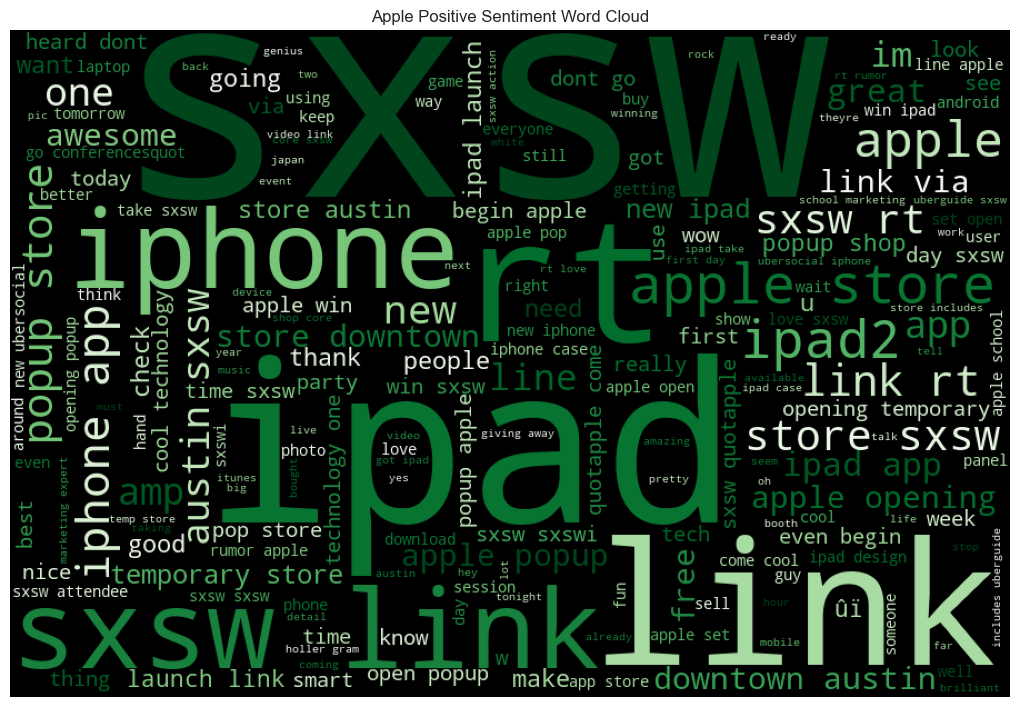

In [50]:
# Get the tweets for Apple with positive sentiment
apple_pos_tweets = df[(df['Company']=='Apple') & (df['Sentiment']=='Positive')]['Tweets'].tolist()

# Join all tweets together into a single string
apple_pos_words = ' '.join([tweet for sublist in apple_pos_tweets for tweet in sublist])

# Create a word cloud for positive sentiment words for Apple
wordcloud = WordCloud(width = 900, height = 600, background_color = 'Black', 
                      min_font_size = 10, colormap = 'Greens').generate(apple_pos_words)
plt.figure(figsize = (10, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Apple Positive Sentiment Word Cloud")
plt.show()

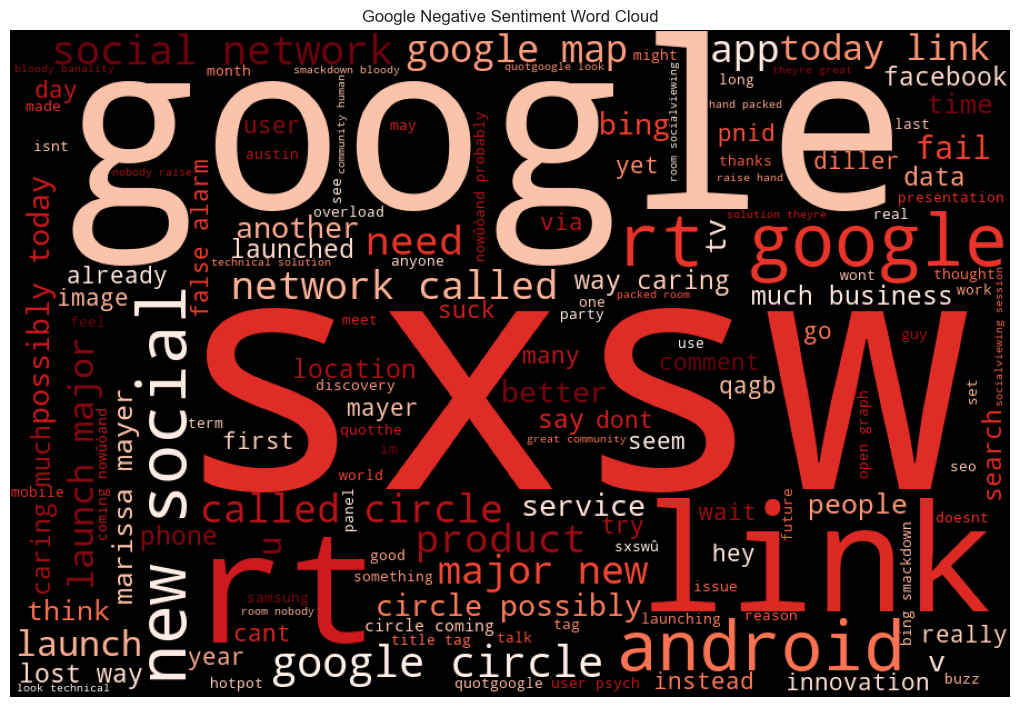

In [51]:
# Get the tweets for Google with negative sentiment
google_neg_tweets = df[(df['Company']=='Google') & (df['Sentiment']=='Negative')]['Tweets'].tolist()

# Join all tweets together into a single string
google_neg_words = ' '.join([tweet for sublist in google_neg_tweets for tweet in sublist])

# Create a word cloud for negative sentiment words for Google
wordcloud = WordCloud(width = 900, height = 600, background_color = 'black', 
                      colormap = 'Reds', min_font_size = 10).generate(google_neg_words)
plt.figure(figsize = (10, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Google Negative Sentiment Word Cloud")
plt.show()

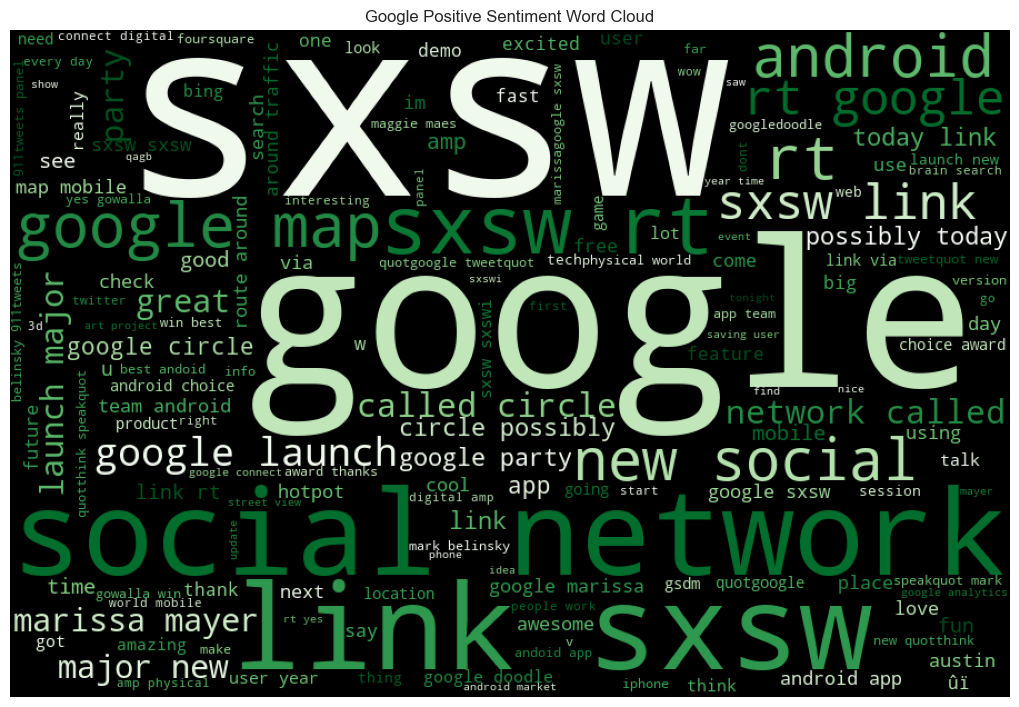

In [52]:
# Get the tweets for Google with positive sentiment
google_pos_tweets = df[(df['Company']=='Google') & (df['Sentiment']=='Positive')]['Tweets'].tolist()

# Join all tweets together into a single string
google_pos_words = ' '.join([tweet for sublist in google_pos_tweets for tweet in sublist])

# Create a word cloud for positive sentiment words for Google
wordcloud = WordCloud(width = 900, height = 600, background_color = 'black', 
                      colormap = 'Greens', min_font_size = 10).generate(google_pos_words)
plt.figure(figsize = (10, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Google Positive Sentiment Word Cloud")
plt.show()

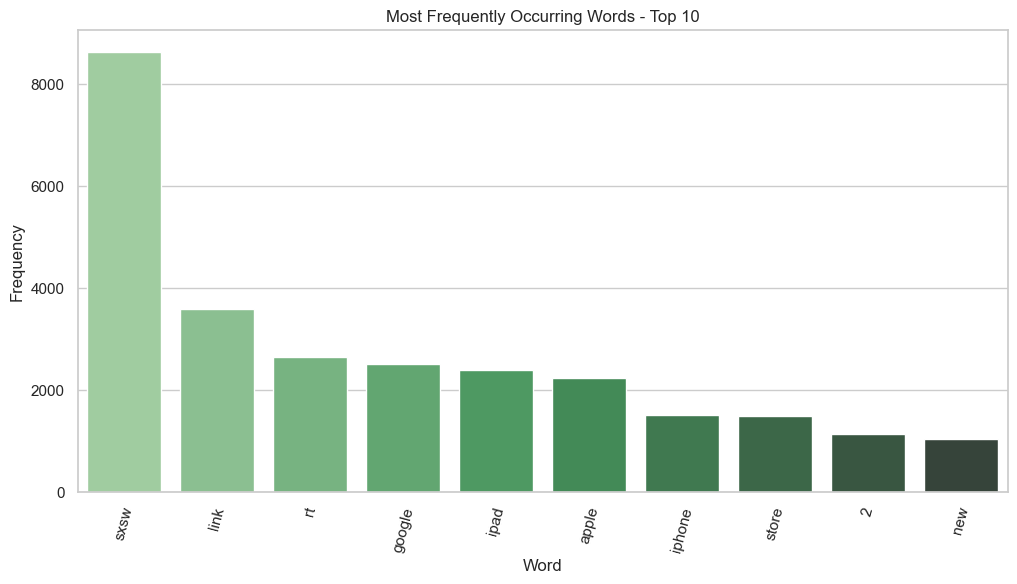

In [76]:
# Flatten the list of lists
flat_tweets = [item for sublist in df['Tweets'] for item in sublist]

# Join the flattened list of strings
all_tweets = ' '.join(flat_tweets)

# Tokenize the string into individual words
tokens = word_tokenize(all_tweets)

# Get the frequency distribution of the words
fdist = FreqDist(tokens)

# Create a dataframe from the frequency distribution
frequency = pd.DataFrame.from_dict(fdist, orient = 'index', columns = ['Frequency'])
frequency.index.name = 'Word'
frequency.reset_index(inplace = True)

# Sort the dataframe by frequency in descending order
frequency.sort_values('Frequency', ascending = False, inplace = True)

# Plot the 30 most frequently occurring words
sns.set_style("whitegrid")
plt.figure(figsize = (12,6))
sns.barplot(x = 'Word', y = 'Frequency', data = frequency.head(10), palette = 'Greens_d')
plt.title('Most Frequently Occurring Words - Top 10')
plt.xticks(rotation = 75)
plt.show()

In [ ]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Convert the tweets data to a matrix of TF-IDF features
X = vectorizer.fit_transform(df['Tweets'])

# Convert the sentiments labels to numeric values
sentiment_map = {'Positive': 1, 'Negative': 0, 'Neutral': -1}
y = df['Sentiment'].map(sentiment_map)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test(X, y, test_size = 0.3, random_state = 42)